<p style="text-align:center;font-size:40px;font-weight:bold;color:#02bd9b">CRAFTY</p>
<p style="text-align:center;font-size:35px;font-weight:bold;color:#fea83a">Simone Passèra</p>

<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Analisi generali dei dati della blockchain</p>

<h2 style="color:#00c4c4">DataSet</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

inputs = pd.read_csv('DataSet/inputs.csv', names=['txId', 'prevTxId', 'prevTxPos'])
outputs = pd.read_csv('DataSet/outputs.csv', names=['txId', 'position', 'addressId', 'amount', 'scripttype'])
mapping = pd.read_csv('DataSet/mapping.csv', names=['hash', 'addressId'])
transactions = pd.read_csv('DataSet/transactions.csv', names=['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee'])

transactions['timestamp'] = pd.to_datetime(transactions['timestamp'], unit='s')

<h2 style="color:#fe5f5e">Analisi n.1</h2>

* Distribuzione del numero di transazioni per blocco (occupazione del blocco), nell’intero
periodo temporale considerato

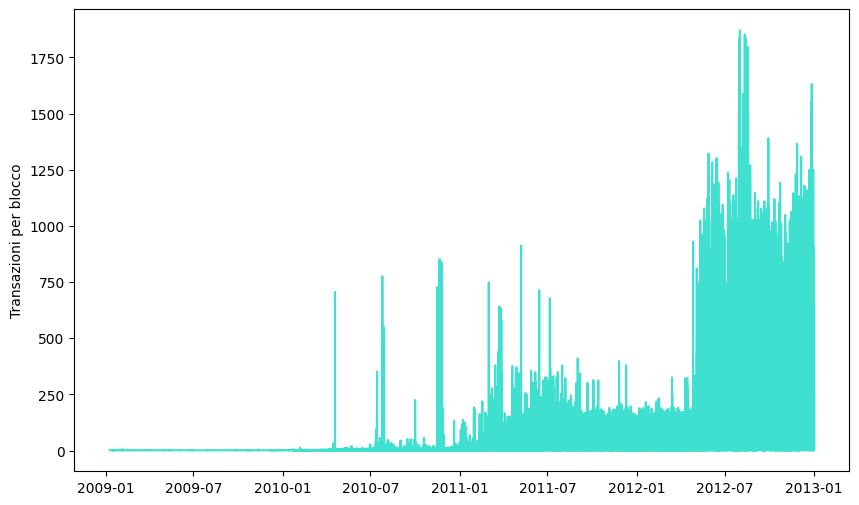

In [2]:
analisi_1 = transactions.groupby('timestamp')['timestamp'].count().reset_index(name='transactions')

plt.figure(figsize=(10,6))
plt.ylabel('Transazioni per blocco')
plt.plot(analisi_1['timestamp'], analisi_1['transactions'], color='turquoise')

<h2 style="color:#fe5f5e">Analisi n.2</h2>

* Evoluzione dell'occupazione dei blocchi nel tempo, considerando intervalli temporali di due
mesi. In questo caso produrre un grafico che riporti il numero di transazioni medie per ogni
periodo considerato

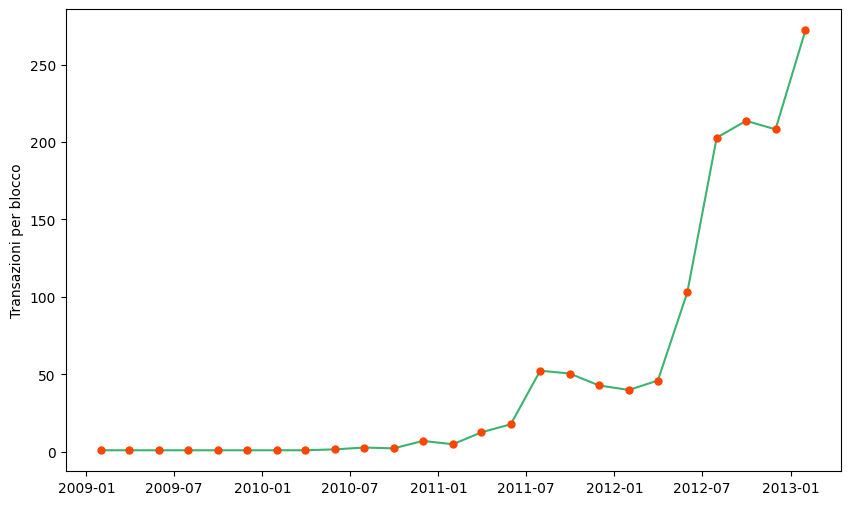

In [27]:
analisi_2 = analisi_1.groupby(pd.Grouper(key='timestamp', freq='2M')).mean().reset_index()

plt.figure(figsize=(10, 6))
plt.ylabel('Transazioni per blocco')
plt.plot(analisi_2['timestamp'], analisi_2['transactions'], color='mediumseagreen', marker='o', markersize=5, markeredgecolor='orangered', markerfacecolor='orangered')

<h2 style="color:#fe5f5e">Analisi n.3</h2>

* Ammontare totale degli **UTXO** al momento dell’ultima transazione registrata nella
blockchain considerata

In [4]:
UTXO = pd.merge(outputs, inputs, how='left', left_on=['txId', 'position'], right_on=['prevTxId', 'prevTxPos'], indicator=True)
UTXO = UTXO.loc[UTXO['_merge'] == 'left_only', 'amount']
print(f"Somma totale UTXO = {UTXO.sum()} BTC")

Somma totale UTXO = 859303372614879 BTC


<h2 style="color:#fe5f5e">Analisi n.4</h2>

* Distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un
valore in output (**UTXO**) e quella che lo consuma, per gli output spesi nel periodo
considerato

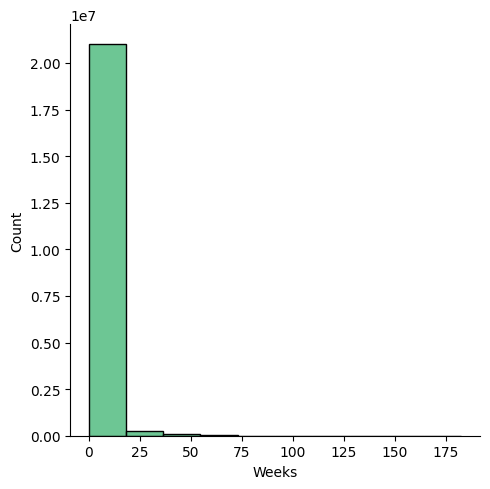

In [24]:
tx_match = pd.merge(outputs, inputs, how='left', left_on=['txId', 'position'], right_on=['prevTxId', 'prevTxPos'], indicator=True)
tx_match = tx_match.loc[tx_match['_merge'] == 'both', ['txId_x', 'txId_y']]
tx_match.rename(columns={'txId_x': 'txId_out', 'txId_y': 'txId_in'}, inplace=True)

tx_out_time = pd.merge(tx_match, transactions, left_on='txId_out', right_on='txId')
tx_out_time.rename(columns={'timestamp': 'time_out'}, inplace=True)
tx_out_time = tx_out_time.loc[:, ['time_out', 'txId_in']]

tx_in_time = pd.merge(tx_out_time, transactions, left_on='txId_in', right_on='txId')
tx_in_time.rename(columns={'timestamp': 'time_in'}, inplace=True)

tx_time = tx_in_time.loc[:, ['time_out', 'time_in']]
tx_time['Weeks'] = (tx_time['time_in'] - tx_time['time_out']) / np.timedelta64(1, 'W')

sns.displot(tx_time['Weeks'], bins=10, color='mediumseagreen')

<h2 style="color:#fe5f5e">Analisi n.5</h2>

* Distribuzione media delle fee per ogni blocco nel periodo considerato.

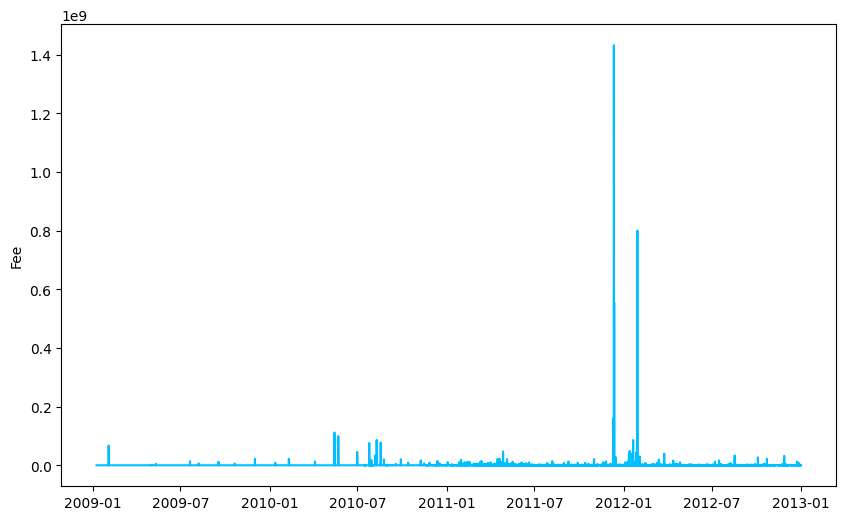

In [6]:
fee = transactions.groupby(['blockId', 'timestamp'])['fee'].mean().reset_index(name='fee_mean')

plt.figure(figsize=(10, 6))
plt.ylabel('Fee')
plt.plot(fee['timestamp'], fee['fee_mean'], color='deepskyblue')

<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Clusterizzazione degli indirizzi di Bitcoin: euristica multi-input</p>

In [7]:
import networkx as nx

in_tx = pd.merge(inputs, transactions, on='txId')
in_tx_out = pd.merge(in_tx, outputs, left_on=['prevTxId', 'prevTxPos'], right_on=['txId', 'position'])

addresses_groups = in_tx_out.groupby('txId_x')['addressId']

G = nx.Graph()

for _, addresses in addresses_groups:
        addr_list = list(set(addresses.tolist()))
        first_addr = addr_list[0]
        
        if len(addr_list) > 1:
            for i in range(1, len(addr_list)):
                G.add_edge(first_addr, addr_list[i])
        else:
            G.add_node(first_addr)

<h2 style="color:#fe5f5e">Analisi n.1</h2>

* Dimensione media, minima e massima dei cluster
* Numero dei cluster

In [23]:
from math import ceil

clusters = nx.connected_components(G)
dimensions = [len(c) for c in clusters]

print(f"Dimensione media dei cluster = {ceil(sum(dimensions) / len(dimensions))} indirizzi")
print(f"Dimensione minima dei cluster = {min(dimensions)} indirizzo")
print(f"Dimensione massima dei cluster = {max(dimensions)} indirizzi")
print(f"Numero dei cluster = {nx.number_connected_components(G)}")

Dimensione media dei cluster = 2 indirizzi
Dimensione minima dei cluster = 1 indirizzo
Dimensione massima dei cluster = 259773 indirizzi
Numero dei cluster = 4001940


<h2 style="color:#fe5f5e">Analisi n.2</h2>

* Distribuzione delle dimensioni dei cluster

Text(0.5, 9.444444444444438, 'Size')

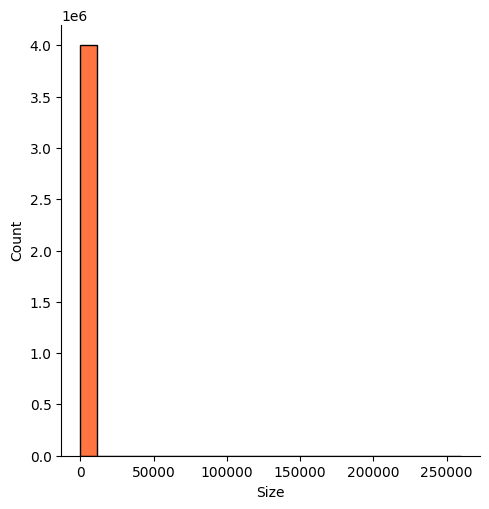

In [35]:
sns.displot(dimensions, color='orangered')
plt.xlabel("Size")

<p style="text-align:center;font-size:25px;font-weight:bold;color:#2b96de">Deanonimizzazione degli indirizzi</p>